In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

下载数据

In [2]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

整理数据集

In [3]:
#@save
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))
labels

# 训练样本 : 1000
# 类别 : 10


{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

In [4]:
collections.Counter(labels.values()).most_common()[-1][1]

85

In [5]:
for train_file in os.listdir(os.path.join(data_dir, 'test')):
    print(train_file.split('.'))

['126979', 'png']
['180981', 'png']
['288998', 'png']
['45986', 'png']
['99987', 'png']


In [6]:
#@save
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))    # 所有文件重新copy 到 train_valid_test/train_valid , 并分类存放在类别目录中   
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))      # 一定比例 valid_ratio 的文件 copy 到 train_valid_test/valid  ，并分类存放在类别目录中， 用于验证
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))      # 多数文件 copy 到 train_valid_test/train 目录，并分类存放在类别目录中， 用于训练
    return n_valid_per_label

In [7]:
#@save
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

In [8]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [9]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

图像增广

In [10]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    #torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
     ])

In [11]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
    ])

读取数据数据集

In [12]:
ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test','valid'),
    transform=transform_train)



In [13]:
ds

Dataset ImageFolder
    Number of datapoints: 80
    Root location: ..\data\kaggle_cifar10_tiny\train_valid_test\valid
    StandardTransform
Transform: Compose(
               Resize(size=40, interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(32, 32), scale=(0.64, 1.0), ratio=(1.0, 1.0), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [14]:
print(ds.classes)  #根据分的文件夹的名字来确定的类别
print(ds.class_to_idx) #按顺序为这些类别定义索引为0,1...
print(ds.imgs) #返回从所有文件夹中得到的图片的路径以及其类别

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
[('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\airplane\\116.png', 0), ('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\airplane\\117.png', 0), ('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\airplane\\130.png', 0), ('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\airplane\\166.png', 0), ('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\airplane\\180.png', 0), ('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\airplane\\186.png', 0), ('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\airplane\\190.png', 0), ('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\airplane\\200.png', 0), ('..\\data\\kaggle_cifar10_tiny\\train_valid_test\\valid\\automobile\\100.png', 1), ('..\\data\\kaggle_cifar10_tiny\\train_valid_te

In [15]:
train_iter = torch.utils.data.DataLoader( ds, batch_size, shuffle=True, drop_last=True)

In [16]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

In [17]:


valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [18]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

定义模型

残差块， 此代码生成两种类型的网络： 一种是当use_1x1conv=False时，应用ReLU非线性函数之前，将输入添加到输出。 另一种是当use_1x1conv=True时，添加通过
卷积调整通道和分辨率。

In [19]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv = False, strides =1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,num_channels,kernel_size=3, padding=1,stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3, padding=1,)
        self.bn2 = nn.BatchNorm2d(num_channels)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels,num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
    
    def forward(self, X):
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = F.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)

        if self.conv3:
            X = self.conv3(X)
        Y += X
        
        Y = F.relu(Y)
        return Y
    

ResNet 模块

In [20]:
def resnet_block(input_channels, num_channels, num_residuals, first_block = False):
    blk = []
    for i in range(num_residuals):
        if i ==0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Residual Net

In [21]:
def residualNet( in_channels=1, num_classes =10):
    '''  
    b1 =nn.Sequential(nn.Conv2d(in_channels,64, kernel_size=7, stride=2, padding=3),
                  nn.BatchNorm2d(64), nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride= 2, padding=1)                  
                  )
    '''
    b1 =nn.Sequential(nn.Conv2d(in_channels,64, kernel_size=3, stride=1, padding=1),
                  nn.BatchNorm2d(64), nn.ReLU(),
                #  nn.MaxPool2d(kernel_size=3, stride= 2, padding=1)                  
                  )
    b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
    b3 = nn.Sequential(*resnet_block(64,128,2))
    b4 = nn.Sequential(*resnet_block(128,256,2))
    b5 = nn.Sequential(*resnet_block(256,512,2))
    net = nn.Sequential(b1, b2,b3,b4,b5, 
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(),
                        nn.Linear(512,num_classes))
    return net

In [22]:
def get_net(input_channels, num_classes):
    net = residualNet(input_channels,num_classes)
   # net =  d2l.resnet18(num_classes, 3)
    return net

定义训练函数

In [23]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

训练和验证模型

train loss 0.545, train acc 0.809, valid acc 0.453
1106.0 examples/sec on [device(type='cuda', index=0)]


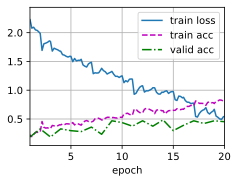

In [24]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay = 4, 0.9

net = get_net(3,len(set(labels.values())))
loss = nn.CrossEntropyLoss(reduction="none")

train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

在 Kaggle 上对测试集进行分类并提交结果

train loss 0.702, train acc 0.753
1278.6 examples/sec on [device(type='cuda', index=0)]


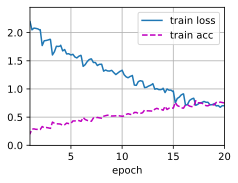

In [25]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)